In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import gaussian
from skimage.morphology import erosion, disk
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import gabor
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

# Define dataset paths
benign_path = "E:\\IQ-OTHNCCD _Lung _Cancer_Dataset\\Benign cases"
malignant_path = "E:\\IQ-OTHNCCD _Lung _Cancer_Dataset\\Malignant cases"
normal_path = "E:\\IQ-OTHNCCD _Lung _Cancer_Dataset\\Normal cases"

# Bit-plane slicing function (extracts 7th bit plane)
def bit_plane_slicing(img, bit=7):
    return np.bitwise_and(img, 1 << bit)

# Otsu's thresholding function
def otsu_threshold(img):
    _, thresh_img = cv2.threshold((img * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh_img / 255.0  # Normalize back to [0, 1]

# Preprocessing pipeline with bit-plane slicing + Gaussian + Erosion + Threshold
def preprocess_image(img):
    img_resized = cv2.resize(img, (128, 128))
    img_bitplane = bit_plane_slicing(img_resized)
    img_gaussian = gaussian(img_bitplane, sigma=1)
    img_erosion = erosion(img_gaussian, disk(1))
    img_threshold = otsu_threshold(img_erosion)
    return img_threshold

# Feature extraction using Gabor filters and GLCM
def extract_features(img):
    gabor_responses = [gabor(img, frequency=0.6)[0], gabor(img, frequency=0.3)[0]]
    gabor_features = np.array([response.mean() for response in gabor_responses])
    
    glcm = graycomatrix((img * 255).astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    entropy = -np.sum(glcm * np.log2(glcm + (glcm == 0)))  # Avoid log(0)
    energy = graycoprops(glcm, 'ASM')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    
    return np.hstack([gabor_features, contrast, homogeneity, entropy, energy, correlation])

# Load and process all images
def load_images_with_features(folder, label):
    features, labels = [], []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = preprocess_image(img)
            features.append(extract_features(img))
            labels.append(label)
    return features, labels

# Load dataset
benign_features, benign_labels = load_images_with_features(benign_path, label=0)
malignant_features, malignant_labels = load_images_with_features(malignant_path, label=1)
normal_features, normal_labels = load_images_with_features(normal_path, label=2)

# Combine data
X = np.array(benign_features + malignant_features + normal_features)
y = np.array(benign_labels + malignant_labels + normal_labels)

# Handle imbalance using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality reduction with PCA
pca_components = min(X_train.shape[0], X_train.shape[1])
pca = PCA(n_components=pca_components)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# SVM training with hyperparameter tuning
param_grid = {'C': [1, 10, 50], 'kernel': ['poly', 'rbf'], 'degree': [2, 3, 4]}
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_

# Evaluation
y_pred = best_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant', 'Normal'], 
            yticklabels=['Benign', 'Malignant', 'Normal'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Hyperparameter tuning results
results = grid_search.cv_results_
c_values = results['param_C'].data
degrees = results['param_degree'].data
kernels = results['param_kernel'].data
mean_test_scores = results['mean_test_score']

# Plot hyperparameter performance
acc_data = {f"C={c}, Kernel={kernel}, Degree={degree}": score 
            for c, kernel, degree, score in zip(c_values, kernels, degrees, mean_test_scores)}

plt.figure(figsize=(10, 5))
plt.bar(acc_data.keys(), acc_data.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Hyperparameters")
plt.ylabel("Accuracy")
plt.title("SVM Model Accuracy for Different Hyperparameters")
plt.tight_layout()
plt.show()


SVM Accuracy: 89.61%
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       106
           1       0.99      0.94      0.97       125
           2       0.89      0.81      0.85       106

    accuracy                           0.90       337
   macro avg       0.90      0.89      0.89       337
weighted avg       0.90      0.90      0.90       337



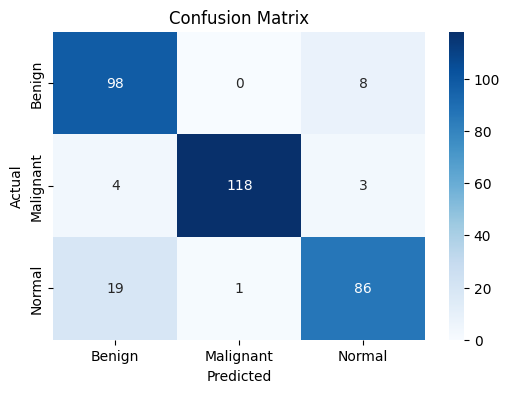

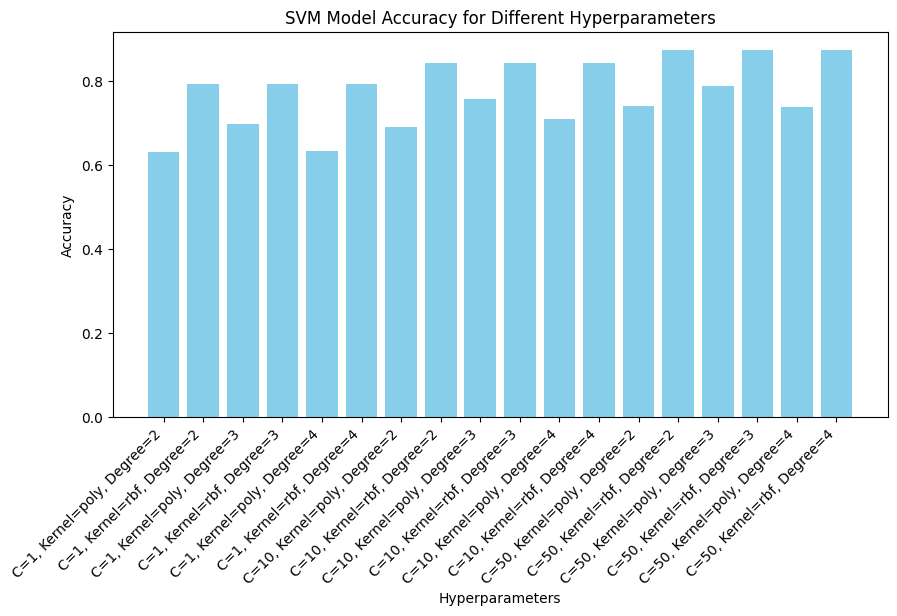

In [9]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import gaussian
from skimage.morphology import erosion, disk
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import gabor
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

# Define dataset paths
benign_path = "E:\\IQ-OTHNCCD _Lung _Cancer_Dataset\\Benign cases"
malignant_path = "E:\\IQ-OTHNCCD _Lung _Cancer_Dataset\\Malignant cases"
normal_path = "E:\\IQ-OTHNCCD _Lung _Cancer_Dataset\\Normal cases"

def bit_plane_slicing(img, bit=7):
    return np.bitwise_and(img, 1 << bit)

def preprocess_image(img):
    img_resized = cv2.resize(img, (128, 128))
    img_bitplane = bit_plane_slicing(img_resized)
    img_gaussian = gaussian(img_resized, sigma=1)
    img_erosion = erosion(img_gaussian, disk(1))
    return img_erosion


def extract_features(img):
    gabor_responses = [gabor(img, frequency=0.6)[0], gabor(img, frequency=0.3)[0]]
    gabor_features = np.array([response.mean() for response in gabor_responses])
    
    glcm = graycomatrix((img * 255).astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    entropy = -np.sum(glcm * np.log2(glcm + (glcm == 0)))
    energy = graycoprops(glcm, 'ASM')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    
    return np.hstack([gabor_features, contrast, homogeneity, entropy, energy, correlation])

def load_images_with_features(folder, label):
    features, labels = [], []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = preprocess_image(img)
            features.append(extract_features(img))
            labels.append(label)
    return features, labels

benign_features, benign_labels = load_images_with_features(benign_path, label=0)
malignant_features, malignant_labels = load_images_with_features(malignant_path, label=1)
normal_features, normal_labels = load_images_with_features(normal_path, label=2)

X = np.array(benign_features + malignant_features + normal_features)
y = np.array(benign_labels + malignant_labels + normal_labels)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


pca_components = min(X_train.shape[0], X_train.shape[1])
pca = PCA(n_components=pca_components)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# SVM with GridSearchCV
param_grid = {'C': [1, 10, 50], 'kernel': ['poly', 'rbf'], 'degree': [2, 3, 4]}
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_

# Evaluate SVM
y_pred = best_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant', 'Normal'], yticklabels=['Benign', 'Malignant', 'Normal'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Hyperparameter Tuning Results
results = grid_search.cv_results_
c_values = results['param_C'].data
degrees = results['param_degree'].data
kernels = results['param_kernel'].data
mean_test_scores = results['mean_test_score']

acc_data = {f"C={c}, Kernel={kernel}, Degree={degree}": score for c, kernel, degree, score in zip(c_values, kernels, degrees, mean_test_scores)}

plt.figure(figsize=(10, 5))
plt.bar(acc_data.keys(), acc_data.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Hyperparameters")
plt.ylabel("Accuracy")
plt.title("SVM Model Accuracy for Different Hyperparameters")
plt.show()

In [15]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage.morphology import erosion, disk
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import gabor
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define dataset paths
benign_path = "E:\\IQ-OTHNCCD _Lung _Cancer_Dataset\\Benign cases"
malignant_path = "E:\\IQ-OTHNCCD _Lung _Cancer_Dataset\\Malignant cases"
normal_path = "E:\\IQ-OTHNCCD _Lung _Cancer_Dataset\\Normal cases"

# Bit-plane slicing (7th bit)
def bit_plane_slicing(img, bit=7):
    return np.bitwise_and(img, 1 << bit)

# Otsu's thresholding
def otsu_threshold(img):
    _, thresh = cv2.threshold((img * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh / 255.0  # Normalize back to [0, 1]

# Preprocessing with bit-plane, Gaussian, erosion, and Otsu mask application
def preprocess_image(img):
    img_resized = cv2.resize(img, (128, 128))
    img_bit = bit_plane_slicing(img_resized)
    img_blur = gaussian(img_bit, sigma=1)
    img_eroded = erosion(img_blur, disk(1))
    mask = otsu_threshold(img_eroded)
    return img_resized * mask  # Apply mask to grayscale image (preserve intensity)

# Gabor + GLCM feature extraction
def extract_features(img):
    gabor1 = gabor(img, frequency=0.6)[0]
    gabor2 = gabor(img, frequency=0.3)[0]
    gabor_features = [gabor1.mean(), gabor2.mean()]

    glcm = graycomatrix((img * 255).astype(np.uint8), distances=[1], angles=[0],
                        levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    entropy = -np.sum(glcm * np.log2(glcm + (glcm == 0)))  # avoid log(0)
    energy = graycoprops(glcm, 'ASM')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    return np.array(gabor_features + [contrast, homogeneity, entropy, energy, correlation])

# Load images and labels
def load_images_with_features(folder, label):
    features, labels = [], []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            processed_img = preprocess_image(img)
            feature_vector = extract_features(processed_img)
            features.append(feature_vector)
            labels.append(label)
    return features, labels

# Load dataset
benign_features, benign_labels = load_images_with_features(benign_path, label=0)
malignant_features, malignant_labels = load_images_with_features(malignant_path, label=1)
normal_features, normal_labels = load_images_with_features(normal_path, label=2)

X = np.array(benign_features + malignant_features + normal_features)
y = np.array(benign_labels + malignant_labels + normal_labels)

# Train-test split (70/30), stratified to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Evaluate SVM with different kernels manually
kernels = ['linear', 'rbf', 'poly']
for kernel in kernels:
    print(f"\n========== Kernel: {kernel.upper()} ==========")
    model = SVC(kernel=kernel)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant", "Normal"]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))



========== Kernel: LINEAR ==========
Accuracy: 84.24%
Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00        36
   Malignant       0.97      0.93      0.95       169
      Normal       0.72      0.97      0.83       125

    accuracy                           0.84       330
   macro avg       0.56      0.63      0.59       330
weighted avg       0.77      0.84      0.80       330

Confusion Matrix:
[[  0   1  35]
 [  0 157  12]
 [  0   4 121]]

========== Kernel: RBF ==========
Accuracy: 84.85%
Classification Report:


C:\Users\vishn\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vishn\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vishn\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00        36
   Malignant       0.93      0.95      0.94       169
      Normal       0.76      0.95      0.84       125

    accuracy                           0.85       330
   macro avg       0.56      0.63      0.60       330
weighted avg       0.76      0.85      0.80       330

Confusion Matrix:
[[  0   6  30]
 [  0 161   8]
 [  0   6 119]]

========== Kernel: POLY ==========
Accuracy: 79.09%
Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00        36
   Malignant       0.83      0.95      0.88       169
      Normal       0.75      0.80      0.77       125

    accuracy                           0.79       330
   macro avg       0.52      0.58      0.55       330
weighted avg       0.71      0.79      0.75       330

Confusion Matrix:
[[  0  10  26]
 [  0 161   8]
 [  1  24 100]]
